# Solar Power Generation Prediction

<img src="santnu_new.jpg">

The above image is a PV inverter, which is used in a PV system for converting DC power to AC power, so that it can be used with conventional utility-powered appliances. It is heart of PV systems because PV array is a DC source, an inverter is required to convert the dc power to normal ac power that is used in our homes and offices.

## Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split

## Data Reading

In [3]:
plant_df = pd.read_csv("Plant_1_Generation_Data.csv")
plant_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [4]:
plant_df.shape

(68778, 7)

In [5]:
plant_df_columns = plant_df.columns.tolist()
plant_df[plant_df_columns].isnull().sum()

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

## Preprocessing

In [6]:
plant_df['DATE_TIME']= pd.to_datetime(plant_df['DATE_TIME'],format='%d-%m-%Y %H:%M') 

In [7]:
SOURCE_KEY_list = plant_df['SOURCE_KEY'].unique()
day_of_month_list = plant_df['DATE_TIME'].dt.day.unique()
month_list = plant_df['DATE_TIME'].dt.month.unique()

In [8]:
def data_collection():
    main_df = pd.DataFrame()
    for i in day_of_month_list:
        for j in month_list:
            df=plant_df[(plant_df.DATE_TIME.dt.month == j) & (plant_df.DATE_TIME.dt.day == i) ][-len(SOURCE_KEY_list):]
            df = df.drop(['PLANT_ID', 'DC_POWER', 'AC_POWER', 'TOTAL_YIELD'],axis = 1)
            df = df[df.DAILY_YIELD != 0]
            main_df = main_df.append(df, ignore_index=True)
    return main_df
main_df = data_collection()

In [9]:
main_df.index = main_df.DATE_TIME.dt.date.astype("datetime64[ns]")
main_df = main_df.drop(["DATE_TIME"],axis=1)

In [10]:
main_df.head()

,SOURCE_KEY,DAILY_YIELD
DATE_TIME,,
2020-05-15,1BY6WEcLGh8j5v7,5754.0
2020-05-15,McdE0feGgRqW7Ca,6471.0
2020-05-15,YxYtjZvoooNbGkE,6291.0
2020-05-15,ZoEaEvLYb1n2sOq,6261.0
2020-05-15,bvBOhCH3iADSZry,5707.0


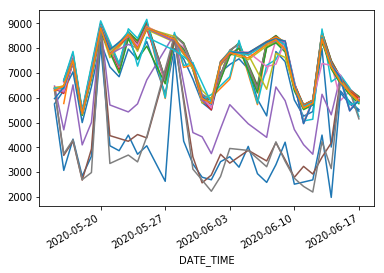

In [11]:
## Identifying faulty source key
Unfault_SOURCE_KEY = main_df.SOURCE_KEY.unique()
for i in SOURCE_KEY_list:
    df = main_df[main_df.SOURCE_KEY == i]
    df.DAILY_YIELD.plot()
plt.show()

## Model Building

In [12]:
main_df['dayofweek'] = main_df.index.dayofweek
main_df['quarter'] = main_df.index.quarter
main_df['month'] = main_df.index.month
main_df['year'] = main_df.index.year
main_df['dayofyear'] = main_df.index.dayofyear
main_df['dayofmonth'] = main_df.index.day
main_df['weekofyear'] = main_df.index.weekofyear

In [13]:
label_encoder = preprocessing.LabelEncoder() 
main_df['SOURCE_KEY']= label_encoder.fit_transform(main_df['SOURCE_KEY']) 
X = main_df[['SOURCE_KEY','dayofweek', 'quarter','month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y = main_df["DAILY_YIELD"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)

In [14]:
reg = xgb.XGBRegressor(n_estimators=500,
                       objective ='reg:squarederror',
                       learning_rate = 0.16,
                       colsample_bytree=0.6,
                       max_depth = 5,
                       min_child_weight = 6)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50)

[0]	validation_0-rmse:5806.89014	validation_1-rmse:5776.13916
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4942.38184	validation_1-rmse:4930.96289
[2]	validation_0-rmse:4206.47412	validation_1-rmse:4212.51221
[3]	validation_0-rmse:3602.79785	validation_1-rmse:3623.12622
[4]	validation_0-rmse:3089.09644	validation_1-rmse:3127.92578
[5]	validation_0-rmse:2655.24341	validation_1-rmse:2701.15894
[6]	validation_0-rmse:2308.03540	validation_1-rmse:2373.10864
[7]	validation_0-rmse:2032.49365	validation_1-rmse:2118.00049
[8]	validation_0-rmse:1800.23828	validation_1-rmse:1905.94397
[9]	validation_0-rmse:1614.43103	validation_1-rmse:1743.84570
[10]	validation_0-rmse:1433.08142	validation_1-rmse:1571.87524
[11]	validation_0-rmse:1311.17029	validation_1-rmse:1467.71081
[12]	validation_0-rmse:1216.26477	validation_1-rmse:1385.35095
[13]	validation_0-rmse:1105.2277

[131]	validation_0-rmse:363.39194	validation_1-rmse:630.66235
[132]	validation_0-rmse:363.34970	validation_1-rmse:630.62244
[133]	validation_0-rmse:363.31589	validation_1-rmse:630.43292
[134]	validation_0-rmse:363.28564	validation_1-rmse:630.12683
[135]	validation_0-rmse:362.60657	validation_1-rmse:631.82007
[136]	validation_0-rmse:360.81067	validation_1-rmse:630.76764
[137]	validation_0-rmse:359.91531	validation_1-rmse:632.10645
[138]	validation_0-rmse:359.89435	validation_1-rmse:632.14807
[139]	validation_0-rmse:358.99832	validation_1-rmse:633.38287
[140]	validation_0-rmse:358.97580	validation_1-rmse:633.45721
[141]	validation_0-rmse:358.95953	validation_1-rmse:633.52234
[142]	validation_0-rmse:357.81281	validation_1-rmse:634.74689
[143]	validation_0-rmse:357.51294	validation_1-rmse:634.33887
[144]	validation_0-rmse:356.20740	validation_1-rmse:634.48090
[145]	validation_0-rmse:355.37653	validation_1-rmse:634.61932
[146]	validation_0-rmse:354.21039	validation_1-rmse:635.07098
[147]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.16, max_delta_step=0, max_depth=5,
       min_child_weight=6, missing=nan, monotone_constraints='()',
       n_estimators=500, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

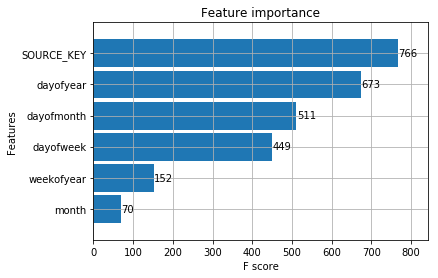

In [15]:
plot_importance(reg, height=0.9)

In [16]:
y_pred = reg.predict(X_test)


In [17]:
#predictions
# n = number of days to predict future generation
def create_df(n):
    prediction_df = pd.DataFrame()
    for i in range(0,n):
        df = pd.DataFrame()
        df["SOURCE_KEY"] = Unfault_SOURCE_KEY
        df["DATE_TIME"] = "2020-06-%d"%(i+15)
        prediction_df = prediction_df.append(df)
    prediction_df['DATE_TIME']= pd.to_datetime(prediction_df['DATE_TIME']) 
    prediction_df.index = prediction_df.DATE_TIME.dt.date.astype("datetime64[ns]")
    prediction_df = prediction_df.drop(["DATE_TIME"],axis=1)
    prediction_df['dayofweek'] = prediction_df.index.dayofweek
    prediction_df['quarter'] = prediction_df.index.quarter
    prediction_df['month'] = prediction_df.index.month
    prediction_df['year'] = prediction_df.index.year
    prediction_df['dayofyear'] = prediction_df.index.dayofyear
    prediction_df['dayofmonth'] = prediction_df.index.day
    prediction_df['weekofyear'] = prediction_df.index.week
    return prediction_df

In [18]:
x = create_df(2)
df_copy = x.copy() 
x['SOURCE_KEY'] = label_encoder.fit_transform(x['SOURCE_KEY'])

In [19]:
y_prediction = reg.predict(x)

In [20]:
df_copy["DAILY_YIELD_prediction"] = y_prediction

In [21]:
df_copy

,SOURCE_KEY,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,DAILY_YIELD_prediction
DATE_TIME,,,,,,,,,
2020-06-15,1BY6WEcLGh8j5v7,0,2,6,2020,167,15,25,6064.892578
2020-06-15,McdE0feGgRqW7Ca,0,2,6,2020,167,15,25,6285.535156
2020-06-15,YxYtjZvoooNbGkE,0,2,6,2020,167,15,25,6743.089355
2020-06-15,ZoEaEvLYb1n2sOq,0,2,6,2020,167,15,25,6873.565918
2020-06-15,bvBOhCH3iADSZry,0,2,6,2020,167,15,25,5246.226074
2020-06-15,iCRJl6heRkivqQ3,0,2,6,2020,167,15,25,6955.446289
2020-06-15,pkci93gMrogZuBj,0,2,6,2020,167,15,25,6864.187012
2020-06-15,rGa61gmuvPhdLxV,0,2,6,2020,167,15,25,6851.119141
2020-06-15,sjndEbLyjtCKgGv,0,2,6,2020,167,15,25,5664.237305
